# 03. Convolutional Neural Networks and Computer Vision with TensorFlow

So far we've covered the basics of TensorFlow and built a handful of models to work across different problems.

Now we're going to get specific and see how a special kind of neural network, [convolutional neural networks (CNNs)](https://en.wikipedia.org/wiki/Convolutional_neural_network) can be used for computer vision (detecting patterns in visual data).

>🔑 Note: In deep learning, many different kinds of model architectures can be used for different problems. For example, you could use a convolutional neural network for making predictions on image data and/or text data. However, in practice some architectures typically work better than others.

For example, you might want to:

* Classify whether a picture of food contains pizza 🍕 or steak 🥩 (we're going to do this)
* Detect whether or not an object appears in an image (e.g. did a specific car pass through a security camera?)
In this notebook, we're going to follow the TensorFlow modelling workflow we've been following so far whilst learning about how to build and use CNNs.

### What we're going to go through

Specifically, we're going to go through the follow with TensorFlow:

* Getting a dataset to work with
* Architecture of a convolutional neural network
* A quick end-to-end example (what we're working towards)
* Steps in modelling for binary image classification with CNNs
  * Becoming one with the data
  * Preparing data for modelling
  * Creating a CNN model (starting with a baseline)
  * Fitting a model (getting it to find patterns in our data)
  * Evaluating a model
  * Improving a model
  * Making a prediction with a trained model
* Steps in modelling for multi-class image classification with CNNs
  * Same as above (but this time with a different dataset)

### Get the data

Because convolutional neural networks work so well with images, to learn more about them, we're going to start with a dataset of images.

The images we're going to work with are from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a collection of 101 different categories of 101,000 (1000 images per category) real-world images of food dishes.

To begin, we're only going to use two of the categories, pizza 🍕 and steak 🥩 and build a binary classifier.

> 🔑 Note: To prepare the data we're using, preprocessing steps such as, moving the images into different subset folders, have been done. To see these preprocessing steps check out [the preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

We'll download the `pizza_steak` subset .zip file and unzip it.

In [1]:
import zipfile

# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-02-20 16:53:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 142.251.8.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  64.3MB/s    in 1.6s    

2022-02-20 16:54:00 (64.3 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [2]:
!ls pizza_steak

test  train


In [3]:
!ls pizza_steak/train/

pizza  steak


In [4]:
!ls pizza_steak/train/steak/

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

In [5]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.
There are 2 directories and 0 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.


In [6]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))

num_steak_images_train

750

In [7]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


Okay, so we've got a collection of 750 training images and 250 testing images of pizza and steak.

Let's look at some.

> 🤔 Note: Whenever you're working with data, it's always good to visualize it as much as possible. Treat your first couple of steps of a project as becoming one with the data. **Visualize, visualize, visualize**.

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)

  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder),1)

    # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


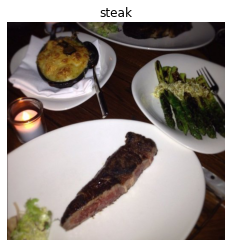

In [9]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="steak")

In [10]:
# View the img (actually just a big array/tensor)
img

array([[[ 10,   5,   9],
        [ 13,   8,  12],
        [ 16,  11,  15],
        ...,
        [ 15,   6,   7],
        [ 12,   6,   6],
        [ 12,   6,   6]],

       [[ 11,   6,  10],
        [ 13,   8,  12],
        [ 16,  11,  15],
        ...,
        [ 11,   5,   5],
        [ 11,   5,   5],
        [ 11,   5,   5]],

       [[ 11,   6,  10],
        [ 14,   9,  13],
        [ 16,  11,  15],
        ...,
        [ 11,   5,   5],
        [ 11,   5,   5],
        [ 11,   5,   5]],

       ...,

       [[ 66,  46,  19],
        [ 81,  60,  33],
        [ 96,  72,  46],
        ...,
        [ 24,  10,   7],
        [ 24,  10,   7],
        [ 24,  10,   7]],

       [[ 66,  46,  19],
        [ 83,  62,  35],
        [ 98,  74,  48],
        ...,
        [ 24,  10,   7],
        [ 24,  10,   7],
        [ 24,  10,   7]],

       [[ 68,  48,  21],
        [ 84,  63,  36],
        [100,  76,  50],
        ...,
        [ 25,  11,  10],
        [ 24,  10,   9],
        [ 24,  10,   9]]

In [11]:
# View the image shape
img.shape # returns (width, height, colour channels)

(512, 512, 3)

Looking at the image shape more closely, you'll see it's in the form `(Width, Height, Colour Channels)`.

In our case, the width and height vary but because we're dealing with colour images, the colour channels value is always 3. This is for different values of red, green and blue (RGB) pixels.

You'll notice all of the values in the `img` array are between 0 and 255. This is because that's the possible range for red, green and blue values.

For example, a pixel with a value `red=0, green=0, blue=255` will look very blue.

So when we build a model to differentiate between our images of pizza and steak, it will be finding patterns in these different pixel values which determine what each class looks like.

>🔑 **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also referred to as **normalize**) their pixel values by dividing the image arrays by 255.

In [12]:
# Get all the pixel values between 0 & 1
img/255. 

array([[[0.03921569, 0.01960784, 0.03529412],
        [0.05098039, 0.03137255, 0.04705882],
        [0.0627451 , 0.04313725, 0.05882353],
        ...,
        [0.05882353, 0.02352941, 0.02745098],
        [0.04705882, 0.02352941, 0.02352941],
        [0.04705882, 0.02352941, 0.02352941]],

       [[0.04313725, 0.02352941, 0.03921569],
        [0.05098039, 0.03137255, 0.04705882],
        [0.0627451 , 0.04313725, 0.05882353],
        ...,
        [0.04313725, 0.01960784, 0.01960784],
        [0.04313725, 0.01960784, 0.01960784],
        [0.04313725, 0.01960784, 0.01960784]],

       [[0.04313725, 0.02352941, 0.03921569],
        [0.05490196, 0.03529412, 0.05098039],
        [0.0627451 , 0.04313725, 0.05882353],
        ...,
        [0.04313725, 0.01960784, 0.01960784],
        [0.04313725, 0.01960784, 0.01960784],
        [0.04313725, 0.01960784, 0.01960784]],

       ...,

       [[0.25882353, 0.18039216, 0.0745098 ],
        [0.31764706, 0.23529412, 0.12941176],
        [0.37647059, 0

## A typical architecture of a convolutional neural network

Convolutional neural networks are no different to other kinds of deep learning neural networks in the fact they can be created in many different ways. What you see below are some components you'd expect to find in a traditional CNN.



<table>
  <thead>
    <tr>
      <th><strong>Hyperparameter/Layer type</strong></th>
      <th><strong>What does it do?</strong></th>
      <th><strong>Typical values</strong></th>
    </tr>
    </thead>
    <tbody>
    <tr>
  <td>Input image(s)</td>
  <td>Target images you'd like to discover patterns in</td>
  <td>Whatever you can take a photo (or video) of</td>
  </tr>
  <tr>
  <td>Input layer</td>
  <td>Takes in target images and preprocesses them for further layers</td>
  <td><code>input_shape = [batch_size, image_height, image_width, color_channels]</code></td>
  </tr>
  <tr>
  <td>Convolution layer</td>
  <td>Extracts/learns the most important features from target images</td>
  <td>Multiple, can create with <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D"><code>tf.keras.layers.ConvXD</code></a> (X can be multiple values)</td>
  </tr>
  <tr>
  <td>Hidden activation</td>
  <td>Adds non-linearity to learned features (non-straight lines)</td>
  <td>Usually ReLU (<a href="https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu"><code>tf.keras.activations.relu</code></a>)</td>
  </tr>
  <tr>
  <td>Pooling layer</td>
  <td>Reduces the dimensionality of learned image features</td>
  <td>Average (<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"><code>tf.keras.layers.AvgPool2D</code></a>) or Max (<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D"><code>tf.keras.layers.MaxPool2D</code></a>)</td>
  </tr>
  <tr>
  <td>Fully connected layer</td>
  <td>Further refines learned features from convolution layers</td>
  <td><a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense"><code>tf.keras.layers.Dense</code></a></td>
  </tr>
  <tr>
  <td>Output layer</td>
  <td>Takes learned features and outputs them in shape of target labels</td>
  <td><code>output_shape = [number_of_classes]</code> (e.g. 3 for pizza, steak or sushi)</td>
  </tr>
  <tr>
  <td>Output activation</td>
  <td>Adds non-linearities to output layer</td>
  <td><a href="https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid"><code>tf.keras.activations.sigmoid</code></a> (binary classification) or <a href="https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax"><code>tf.keras.activations.softmax</code></a></td>
  </tr>
  </tbody>
</table>

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 23s 259ms/step - loss: 0.5636 - accuracy: 0.7280 - val_loss: 0.4458 - val_accuracy: 0.7840
Epoch 2/5
47/47 [==============================] - 11s 233ms/step - loss: 0.4412 - accuracy: 0.8000 - val_loss: 0.3617 - val_accuracy: 0.8340
Epoch 3/5
47/47 [==============================] - 11s 237ms/step - loss: 0.3988 - accuracy: 0.8240 - val_loss: 0.4284 - val_accuracy: 0.8020
Epoch 4/5
47/47 [==============================] - 11s 238ms/step - loss: 0.3606 - accuracy: 0.8453 - val_loss: 0.3023 - val_accuracy: 0.8840
Epoch 5/5
47/47 [==============================] - 11s 241ms/step - loss: 0.3191 - accuracy: 0.8693 - val_loss: 0.3429 - val_accuracy: 0.8580


In [14]:
# Check out the layers in our model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

### 1. Import and become one with the data
Whatever kind of data you're dealing with, it's a good idea to visualize at least 10-100 samples to start to building your own mental model of the data.

In our case, we might notice that the steak images tend to have darker colours where as pizza images tend to have a distinct circular shape in the middle. These might be patterns that our neural network picks up on.

You an also notice if some of your data is messed up (for example, has the wrong label) and start to consider ways you might go about fixing it.

Image shape: (384, 512, 3)
Image shape: (512, 512, 3)


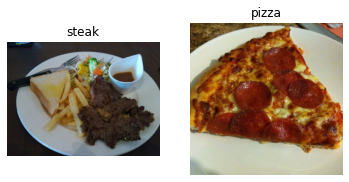

In [15]:
# Visualize data (requires function 'view_random_image' above)
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

### 2. Preprocess the data (prepare it for a model)
One of the most important steps for a machine learning project is creating a training and test set.

In our case, our data is already split into training and test sets. Another option here might be to create a validation set as well, but we'll leave that for now.

For an image classification project, it's standard to have your data seperated into train and test directories with subfolders in each for each class.

To start we define the training and test directory paths.

Our next step is to turn our data into **batches**.

A **batch** is a small subset of the dataset a model looks at during training. For example, rather than looking at 10,000 images at one time and trying to figure out the patterns, a model might only look at 32 images at a time.

It does this for a couple of reasons:

* 10,000 images (or more) might not fit into the memory of your processor (GPU).
* Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.
Why 32?

A batch size of 32 is good for your health.

No seriously, there are many different batch sizes you could use but 32 has proven to be very effective in many different use cases and is often the default for many data preprocessing functions.

To turn our data into batches, we'll first create an instance of `ImageDataGenerator` for each of our datasets.

In [16]:
# Create train and test data generators and rescale the data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

The `ImageDataGenerator` class helps us prepare our images into batches as well as perform transformations on them as they get loaded into the model.

You might've noticed the rescale parameter. This is one example of the transformations we're doing.

Remember from before how we imported an image and it's pixel values were between 0 and 255?

The `rescale` parameter, along with `1/255.` is like saying "divide all of the pixel values by 255". This results in all of the image being imported and their pixel values being normalized (converted to be between 0 and 1).

> 🔑 **Note:** For more transformation options such as data augmentation (we'll see this later), refer to the ImageDataGenerator documentation.

Now we've got a couple of `ImageDataGenerator` instances, we can load our images from their respective directories using the `flow_from_directory` method.

In [17]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Wonderful! Looks like our training dataset has 1500 images belonging to 2 classes (pizza and steak) and our test dataset has 500 images also belonging to 2 classes.

Some things to here:

  * Due to how our directories are structured, the classes get inferred by the subdirectory names in train_dir and test_dir.
  * The target_size parameter defines the input size of our images in (height, width) format.
  * The class_mode value of 'binary' defines our classification problem type. If we had more than two classes, we would use 'categorical'.
  * The batch_size defines how many images will be in each batch, we've used 32 which is the same as the default.
We can take a look at our batched images and labels by inspecting the train_data object.

In [18]:
# Get a sample of the training data batch 
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [19]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.427451  , 0.24313727, 0.07058824],
          [0.4156863 , 0.24313727, 0.06666667],
          [0.39607847, 0.22352943, 0.04705883],
          ...,
          [0.47450984, 0.28235295, 0.12156864],
          [0.48235297, 0.2901961 , 0.12941177],
          [0.48235297, 0.2901961 , 0.12941177]],
 
         [[0.40000004, 0.21568629, 0.04313726],
          [0.4039216 , 0.23137257, 0.05490196],
          [0.427451  , 0.25490198, 0.07843138],
          ...,
          [0.46274513, 0.27058825, 0.10980393],
          [0.46274513, 0.27058825, 0.10980393],
          [0.4666667 , 0.27450982, 0.1137255 ]],
 
         [[0.41176474, 0.227451  , 0.05490196],
          [0.39607847, 0.22352943, 0.04705883],
          [0.39607847, 0.22352943, 0.04705883],
          ...,
          [0.43921572, 0.24705884, 0.08627451],
          [0.45882356, 0.26666668, 0.10588236],
          [0.46274513, 0.27058825, 0.10980393]],
 
         ...,
 
         [[0.38431376, 0.34901962, 0.3137255 ],
          [0.40392

In [20]:
labels

array([0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1.],
      dtype=float32)

### 3. Create a model (start with a baseline)

You might be wondering what your default model architecture should be.

And the truth is, there's many possible answers to this question.

A simple heuristic for computer vision models is to use the model architecture which is performing best on ImageNet (a large collection of diverse images to benchmark different computer vision models).

However, to begin with, it's good to build a smaller model to acquire a baseline result which you try to improve upon.

> 🔑 **Note**: In deep learning a smaller model often refers to a model with less layers than the state of the art (SOTA). For example, a smaller model might have 3-4 layers where as a state of the art model, such as, ResNet50 might have 50+ layers.

In our case, let's take a smaller version of the model that can be found on the [CNN explainer website](https://poloclub.github.io/cnn-explainer/) (`model_1` from above) and build a 3 layer convolutional neural network.

In [21]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [22]:
model_4 = Sequential(
    [
     Conv2D(filters=10,
            kernel_size=3,
            strides=1,
            padding="valid",
            activation="relu",
            input_shape=(224,224,3)),
     Conv2D(10,3,activation="relu"),
     Conv2D(10,3,activation="relu"),
     Flatten(),
     Dense(1,activation="sigmoid")
    ]
)

Great! We've got a simple convolutional neural network architecture ready to go.

And it follows the typical CNN structure of:

Input -> Conv + ReLU layers (non-linearities) -> Pooling layer -> Fully connected (dense layer) as Output
Let's discuss some of the components of the Conv2D layer:

* The "2D" means our inputs are two dimensional (height and width), even though they have 3 colour channels, the convolutions are run on each channel invididually.
* filters - these are the number of "feature extractors" that will be moving over our images.
* kernel_size - the size of our filters, for example, a kernel_size of (3, 3) (or just 3) will mean each filter will have the size 3x3, meaning it will look at a space of 3x3 pixels each time. The smaller the kernel, the more fine-grained features it will extract.
* stride - the number of pixels a filter will move across as it covers the image. A stride of 1 means the filter moves across each pixel 1 by 1. A stride of 2 means it moves 2 pixels at a time.
* padding - this can be either 'same' or 'valid', 'same' adds zeros the to outside of the image so the resulting output of the convolutional layer is the same as the input, where as 'valid' (default) cuts off excess pixels where the filter doesn't fit (e.g. 224 pixels wide divided by a kernel size of 3 (224/3 = 74.6) means a single pixel will get cut off the end.

What's a "feature"?

A feature can be considered any significant part of an image. For example, in our case, a feature might be the circular shape of pizza. Or the rough edges on the outside of a steak.

It's important to note that these features are not defined by us, instead, the model learns them as it applies different filters across the image.

In [23]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

### 4. Fit a model

Our model is compiled, time to fit it.

You'll notice two new parameters here:

 * **steps_per_epoch** - this is the number of batches a model will go through per epoch, in our case, we want our model to go through all batches so it's equal to the length of train_data (1500 images in batches of 32 = 1500/32 = ~47 steps)
 * **validation_steps** - same as above, except for the validation_data parameter (500 test images in batches of 32 = 500/32 = ~16 steps)

In [24]:
# Check lengths of training and test data generators
len(train_data), len(test_data)

(47, 16)

In [25]:
# Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 13s 258ms/step - loss: 1.3735 - accuracy: 0.6200 - val_loss: 0.5344 - val_accuracy: 0.6960
Epoch 2/5
47/47 [==============================] - 11s 238ms/step - loss: 0.4679 - accuracy: 0.7840 - val_loss: 0.4747 - val_accuracy: 0.7840
Epoch 3/5
47/47 [==============================] - 11s 239ms/step - loss: 0.3449 - accuracy: 0.8707 - val_loss: 0.3877 - val_accuracy: 0.8440
Epoch 4/5
47/47 [==============================] - 11s 241ms/step - loss: 0.2138 - accuracy: 0.9320 - val_loss: 0.3920 - val_accuracy: 0.8320
Epoch 5/5
47/47 [==============================] - 11s 242ms/step - loss: 0.1055 - accuracy: 0.9727 - val_loss: 0.3696 - val_accuracy: 0.8460


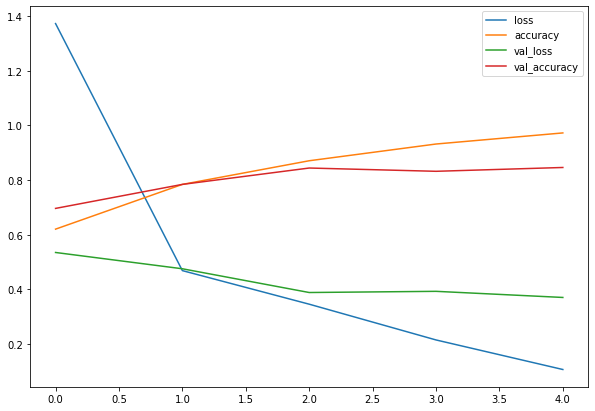

In [26]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7));

In [27]:
# To further inspect our model's training performance, let's separate the accuracy and loss curves.

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

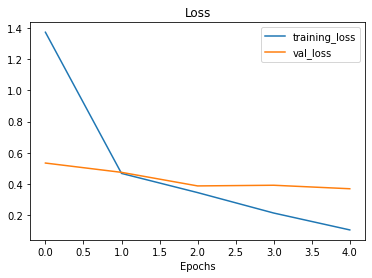

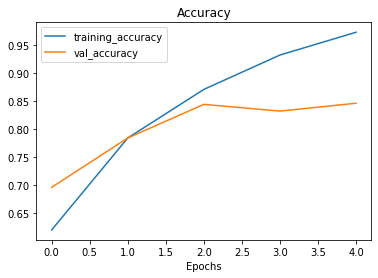

In [28]:
plot_loss_curves(history_4)

In [29]:
# Check out our model's architecture
model_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_1 (Flatten)         (None, 475240)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


## 6. Adjust the model parameters
Fitting a machine learning model comes in 3 steps:

1. Create a basline.
2. Beat the baseline by overfitting a larger model.
3. Reduce overfitting.

So far we've gone through steps 0 and 1.

And there are even a few more things we could try to further overfit our model:

* Increase the number of convolutional layers.
* Increase the number of convolutional filters.
* Add another dense layer to the output of our flattened layer.

But what we'll do instead is focus on getting our model's training curves to better align with eachother, in other words, we'll take on step 2.

Why is reducing overfitting important?

When a model performs too well on training data and poorly on unseen data, it's not much use to us if we wanted to use it in the real world.

Say we were building a pizza vs. steak food classifier app, and our model performs very well on our training data but when users tried it out, they didn't get very good results on their own food images, is that a good experience?

Not really...

So for the next few models we build, we're going to adjust a number of parameters and inspect the training curves along the way.

Namely, we'll build 2 more models:

* A ConvNet with max pooling
* A ConvNet with max pooling and data augmentation

For the first model, we'll follow the modified basic CNN structure:

Input -> Conv layers + ReLU layers (non-linearities) + Max Pooling layers -> Fully connected (dense layer) as Output.

Let's built it. It'll have the same structure as model_4 but with a MaxPool2D() layer after each convolutional layer.

In [30]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

In [31]:
# Compile model (same as model_4)
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [32]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 11s 223ms/step - loss: 0.6581 - accuracy: 0.5887 - val_loss: 0.5552 - val_accuracy: 0.7520
Epoch 2/5
47/47 [==============================] - 10s 215ms/step - loss: 0.5095 - accuracy: 0.7413 - val_loss: 0.4136 - val_accuracy: 0.8220
Epoch 3/5
47/47 [==============================] - 10s 215ms/step - loss: 0.4195 - accuracy: 0.8073 - val_loss: 0.3513 - val_accuracy: 0.8560
Epoch 4/5
47/47 [==============================] - 10s 221ms/step - loss: 0.3872 - accuracy: 0.8307 - val_loss: 0.3792 - val_accuracy: 0.8320
Epoch 5/5
47/47 [==============================] - 10s 220ms/step - loss: 0.3733 - accuracy: 0.8320 - val_loss: 0.3158 - val_accuracy: 0.8720


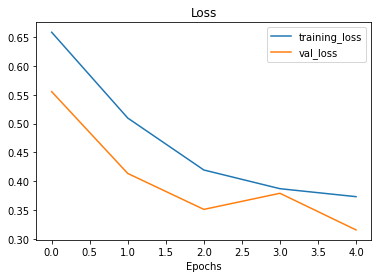

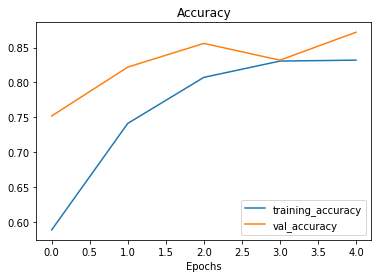

In [33]:
plot_loss_curves(history_5)

Nice! We can see the training curves get a lot closer to eachother. However, our the validation loss looks to start increasing towards the end and in turn potentially leading to overfitting.

Time to dig into our bag of tricks and try another method of overfitting prevention, data augmentation.

First, we'll see how it's done with code then we'll discuss what it's doing.

To implement data augmentation, we'll have to reinstantiate our `ImageDataGenerator` instances.

In [34]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

> 😥 **Question:** What's data augmentation?

**Data augmentation** is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adusting the rotation of an image, fliping it, cropping it or something similar.

Doing this simulates the kind of data a model might be used on in the real world.

If we're building a pizza vs steak application, not all of the images our images our users take might be similar setups to our training data. Using data augmentation gives us another way to prevent overfitting and in turn make our model more generalizable.

>🔑 **Note:** Data augmentation is usally only performed on the training data. Using the `ImageDataGenerator` built-in data augmentation parameters our images are left as they are in the directories but are randomly manipulated when loaded into the model.

In [35]:
# Import data and augment it from training directory

print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                       target_size=(224,224),
                                                       batch_size=32,
                                                       class_mode="binary",
                                                       shuffle=False)

print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode="binary",
                                               shuffle=False)

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode="binary")

Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


In [36]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the sam

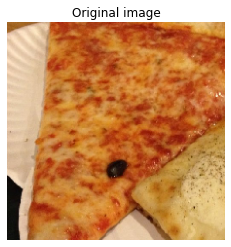

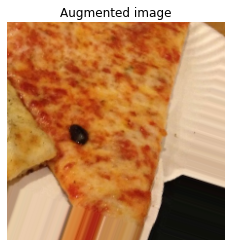

In [37]:
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

After going through a sample of original and augmented images, you can start to see some of the example transformations on the training images.

Notice how some of the augmented images look like slightly warped versions of the original image. This means our model will be forced to try and learn patterns in less-than-perfect images, which is often the case when using real-world images.

>🤔 **Question:** Should I use data augmentation? And how much should I augment?

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

As for how much to data augment, there's no set practice for this. Best to check out the options in the `ImageDataGenerator` class and think about how a model in your use case might benefit from some data augmentation.

Now we've got augmented data, let's try and refit a model on it and see how it affects training.

We'll use the same model as `model_5`.

In [38]:
model_6 = Sequential([
                      Conv2D(10,3,activation="relu",input_shape=(224,224,3)),
                      MaxPool2D(pool_size=2),
                      Conv2D(10,3,activation="relu"),
                      MaxPool2D(),
                      Flatten(),
                      Dense(1,activation="sigmoid")
])

model_6.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

history_6 = model_6.fit(train_data_augmented,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 26s 535ms/step - loss: 0.9911 - accuracy: 0.5013 - val_loss: 0.6737 - val_accuracy: 0.6280
Epoch 2/5
47/47 [==============================] - 25s 533ms/step - loss: 0.6925 - accuracy: 0.5273 - val_loss: 0.6808 - val_accuracy: 0.5180
Epoch 3/5
47/47 [==============================] - 25s 532ms/step - loss: 0.6728 - accuracy: 0.5907 - val_loss: 0.7009 - val_accuracy: 0.5520
Epoch 4/5
47/47 [==============================] - 25s 534ms/step - loss: 0.6998 - accuracy: 0.5860 - val_loss: 0.6452 - val_accuracy: 0.6780
Epoch 5/5
47/47 [==============================] - 25s 529ms/step - loss: 0.6630 - accuracy: 0.6333 - val_loss: 0.6091 - val_accuracy: 0.6020


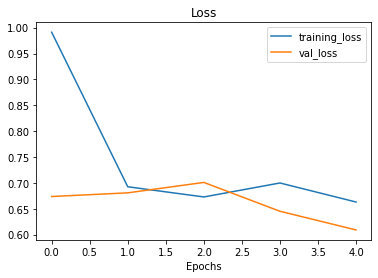

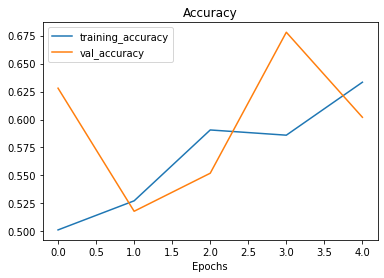

In [39]:
# Check model's performance history training on augmented data
plot_loss_curves(history_6)

It seems our validation loss curve is heading in the right direction but it's a bit jumpy (the most ideal loss curve isn't too spiky but a smooth descent, however, a perfectly smooth loss curve is the equivalent of a fairytale).

Let's see what happens when we shuffle the augmented training data.

In [40]:
# Import data and augment it from directories
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (defau

Found 1500 images belonging to 2 classes.


In [41]:
model_7 = Sequential([
                      Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
                      MaxPool2D(pool_size=2),
                      Conv2D(10,3,activation="relu"),
                      MaxPool2D(),
                      Flatten(),
                      Dense(1,activation="sigmoid")
])

model_7.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

history_7 = model_7.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 26s 534ms/step - loss: 0.6167 - accuracy: 0.6473 - val_loss: 0.4269 - val_accuracy: 0.8060
Epoch 2/5
47/47 [==============================] - 25s 526ms/step - loss: 0.4976 - accuracy: 0.7533 - val_loss: 0.3715 - val_accuracy: 0.8400
Epoch 3/5
47/47 [==============================] - 25s 528ms/step - loss: 0.4836 - accuracy: 0.7600 - val_loss: 0.3458 - val_accuracy: 0.8660
Epoch 4/5
47/47 [==============================] - 25s 526ms/step - loss: 0.4701 - accuracy: 0.7907 - val_loss: 0.3370 - val_accuracy: 0.8480
Epoch 5/5
47/47 [==============================] - 25s 528ms/step - loss: 0.4688 - accuracy: 0.7900 - val_loss: 0.3454 - val_accuracy: 0.8460


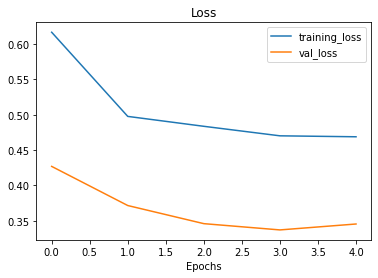

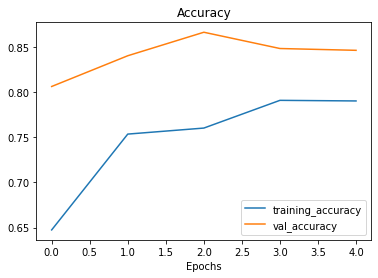

In [42]:
# Check model's performance history training on augmented data
plot_loss_curves(history_7)

Notice with `model_7` how the performance on the training dataset improves almost immediately compared to `model_6`. This is because we shuffled the training data as we passed it to the model using the parameter `shuffle=True` in the `flow_from_directory` method.

This means the model was able to see examples of both pizza and steak images in each batch and in turn be evaluated on what it learned from both images rather than just one kind.

Also, our loss curves look a little bit smoother with shuffled data (comparing `history_6` to `history_7`).

### 7. Repeat until satisfied

We've trained a few model's on our dataset already and so far they're performing pretty good.

Since we've already beaten our baseline, there are a few things we could try to continue to improve our model:

* Increase the number of our model layers (e.g. add more convolutional layers).
* Increase the number of filters in each convolutional layer (e.g. from 10 to 32,64, or 128, these numbers aren't set in stone either, they are usually found through trial and error).
* Train for longer (more epochs).
* Finding and ideal learning rate.
* Get more data (give the model more opportunites to learn).
* Use **transfer learning** to leverage what another image model has learned and adjust it for our own use case.

Adjusting each of these settings (except for the last two) during model development is usually referred to as **hyperparameter tuning**.

You can think of hyperparameter tuning as simialr to adjusting the settings on your oven to cook your favourite dish. Although your oven does most of the cooking for you, you can help it by tweaking the dials.

In [43]:
# Create a CNN model (same as Tiny VGG but for binary classification - https://poloclub.github.io/cnn-explainer/ )
model_8 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_8 = model_8.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 27s 564ms/step - loss: 0.6075 - accuracy: 0.6713 - val_loss: 0.4390 - val_accuracy: 0.7880
Epoch 2/5
47/47 [==============================] - 26s 558ms/step - loss: 0.5119 - accuracy: 0.7533 - val_loss: 0.4178 - val_accuracy: 0.8040
Epoch 3/5
47/47 [==============================] - 26s 555ms/step - loss: 0.4967 - accuracy: 0.7620 - val_loss: 0.4046 - val_accuracy: 0.8320
Epoch 4/5
47/47 [==============================] - 26s 559ms/step - loss: 0.5016 - accuracy: 0.7707 - val_loss: 0.3620 - val_accuracy: 0.8360
Epoch 5/5
47/47 [==============================] - 26s 550ms/step - loss: 0.4833 - accuracy: 0.7833 - val_loss: 0.3745 - val_accuracy: 0.8300


In [44]:
# Check model_8 architecture (same as model_1)
model_8.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_15 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_17 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                 

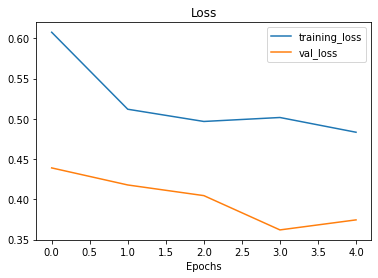

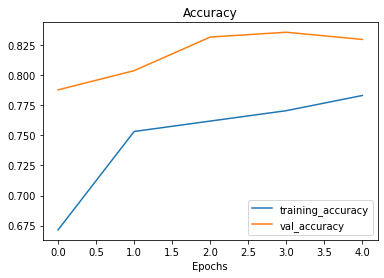

In [45]:
# Check out the TinyVGG model performance
plot_loss_curves(history_8)

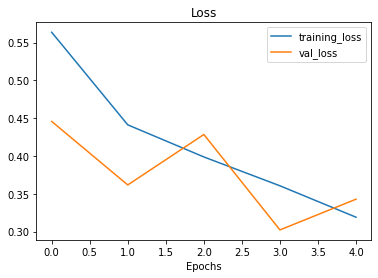

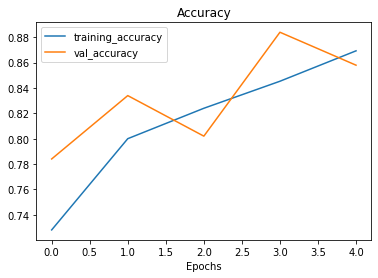

In [46]:
# How does this training curve look compared to the one above?
plot_loss_curves(history_1)

Hmm, our training curves are looking good, but our model's performance on the training and test sets didn't improve much compared to the previous model.

Taking another loook at the training curves, it looks like our model's performance might improve if we trained it a little longer (more epochs).

Perhaps that's something you like to try?

###**Making a prediction with our trained model**
What good is a trained model if you can't make predictions with it?

To really test it out, we'll upload a couple of our own images and see how the model goes.

First, let's remind ourselves of the classnames and view the image we're going to test on.

In [47]:
# Classes we're working with
print(class_names)

['pizza' 'steak']


--2022-02-20 17:04:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.07s   

2022-02-20 17:04:27 (27.4 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



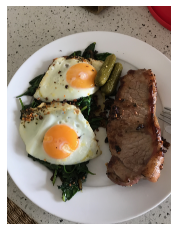

In [48]:
# View our example image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [49]:
# Check the shape of our image
steak.shape

(4032, 3024, 3)

Since our model takes in images of shapes (``224, 224, 3``), we've got to reshape our custom image to use it with our model.

To do so, we can import and decode our image using `tf.io.read_file` (for readining files) and `tf.image` (for resizing our image and turning it into a tensor).

> 🔑 **Note:** For your model to make predictions on unseen data, for example, your own custom images, the custom image has to be in the same shape as your model has been trained on. In more general terms, to make predictions on custom data it has to be in the same form that your model has been trained on.

In [50]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [51]:
# Load in and preprocess our custom image
steak = load_and_prep_image("03-steak.jpeg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

In [53]:
# Make a prediction on our custom image (spoiler: this won't work)
model_8.predict(steak)

ValueError: ignored

There's one more problem...

Although our image is in the same shape as the images our model has been trained on, we're still missing a dimension.

Remember how our model was trained in batches?

Well, the batch size becomes the first dimension.

So in reality, our model was trained on data in the shape of (`batch_size, 224, 224, 3`).

We can fix this by adding an extra to our custom image tensor using `tf.expand_dims`.

In [54]:
# Add an extra axis
print(f"Shape before new dimension: {steak.shape}")
steak = tf.expand_dims(steak, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {steak.shape}")
steak

Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.6377451 , 0.6220588 , 0.57892156],
         [0.6504902 , 0.63186276, 0.5897059 ],
         [0.63186276, 0.60833335, 0.5612745 ],
         ...,
         [0.52156866, 0.05098039, 0.09019608],
         [0.49509802, 0.04215686, 0.07058824],
         [0.52843136, 0.07745098, 0.10490196]],

        [[0.6617647 , 0.6460784 , 0.6107843 ],
         [0.6387255 , 0.6230392 , 0.57598037],
         [0.65588236, 0.63235295, 0.5852941 ],
         ...,
         [0.5352941 , 0.06862745, 0.09215686],
         [0.529902  , 0.05931373, 0.09460784],
         [0.5142157 , 0.05539216, 0.08676471]],

        [[0.6519608 , 0.6362745 , 0.5892157 ],
         [0.6392157 , 0.6137255 , 0.56764704],
         [0.65637255, 0.6269608 , 0.5828431 ],
         ...,
         [0.53137255, 0.06470589, 0.08039216],
         [0.527451  , 0.06862745, 0.1       ],
         [0.52254903, 0.05196078, 0.0872549 ]],

        ...,

        [[0.49313724, 0.42745098, 

In [55]:
# Make a prediction on custom image tensor
pred = model_8.predict(steak)
pred

array([[0.8550797]], dtype=float32)

In [56]:
# We can index the predicted class by rounding the prediction probability
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'steak'

In [57]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

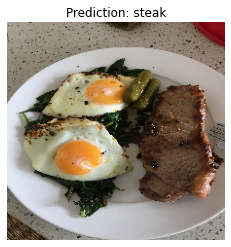

In [58]:
# Test our model on a custom image
pred_and_plot(model_8, "03-steak.jpeg", class_names)

--2022-02-20 17:05:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.08s   

2022-02-20 17:05:54 (36.0 MB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]



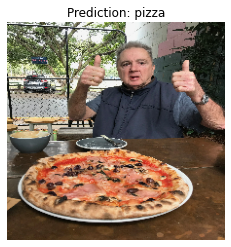

In [59]:
# Download another test image and make a prediction on it
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg 
pred_and_plot(model_8, "03-pizza-dad.jpeg", class_names)

## Multi-class Classification

We've referenced the TinyVGG architecture from the CNN Explainer website multiple times through this notebook, however, the CNN Explainer website works with 10 different image classes, where as our current model only works with two classes (pizza and steak).

> 🛠 **Practice:**Before scrolling down, how do you think we might change our model to work with 10 classes of the same kind of images? Assume the data is in the same style as our two class problem.

Remember the steps we took before to build our pizza 🍕 vs. steak 🥩 classifier?

How about we go through those steps again, except this time, we'll work with 10 different types of food.

  1. Become one with the data (visualize, visualize, visualize...)
  2. Preprocess the data (prepare it for a model)
  3. Create a model (start with a baseline)
  4. Fit the model
  5. Evaluate the model
  6. Adjust different parameters and improve model (try to beat your baseline)
  7. Repeat until satisfied

###1. Import and become one with the data
Again, we've got a subset of the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101). In addition to the pizza and steak images, we've pulled out another eight classes.

In [60]:
import zipfile

# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-02-20 17:05:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  83.8MB/s    in 6.6s    

2022-02-20 17:06:06 (75.6 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [61]:
import os

# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.

In [62]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [63]:
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Image shape: (512, 512, 3)


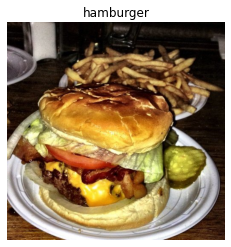

In [64]:
# View a random image from the training dataset
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name

### 2. Preprocess the data (prepare it for a model)

After going through a handful of images (it's good to visualize at least 10-100 different examples), it looks like our data directories are setup correctly.

Time to preprocess the data.

In [65]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


###3. Create a model (start with a baseline)
We can use the same model (TinyVGG) we used for the binary classification problem for our multi-class classification problem with a couple of small tweaks.

Namely:

* Changing the output layer to use have 10 ouput neurons (the same number as the number of classes we have).
* Changing the output layer to use `'softmax'` activation instead of `'sigmoid'` activation.
* Changing the loss function to be `'categorical_crossentropy'` instead of `'binary_crossentropy'`.

In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model (a clone of model_8, except to be multi-class)
model_9 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_9.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

###4. Fit a model

In [67]:
# Fit the model
history_9 = model_9.fit(train_data, # now 10 different classes 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 58s 244ms/step - loss: 2.0951 - accuracy: 0.2405 - val_loss: 2.0069 - val_accuracy: 0.2844
Epoch 2/5
235/235 [==============================] - 55s 232ms/step - loss: 1.9068 - accuracy: 0.3363 - val_loss: 1.9232 - val_accuracy: 0.3156
Epoch 3/5
235/235 [==============================] - 55s 236ms/step - loss: 1.6728 - accuracy: 0.4227 - val_loss: 1.9636 - val_accuracy: 0.3160
Epoch 4/5
235/235 [==============================] - 56s 238ms/step - loss: 1.2797 - accuracy: 0.5751 - val_loss: 2.1498 - val_accuracy: 0.3016
Epoch 5/5
235/235 [==============================] - 55s 235ms/step - loss: 0.8011 - accuracy: 0.7303 - val_loss: 2.6864 - val_accuracy: 0.2900


### 5. Evaluate the model

In [68]:
model_9.evaluate(test_data)

79/79 [==============================] - 12s 156ms/step - loss: 2.6864 - accuracy: 0.2900


[2.6864256858825684, 0.28999999165534973]

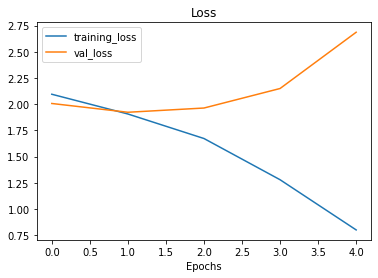

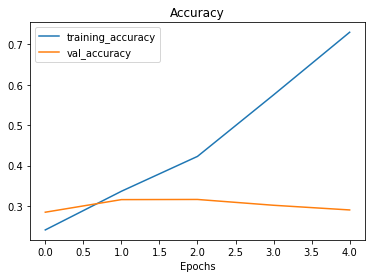

In [69]:
# Check out the model's loss curves on the 10 classes of data (note: this function comes from above in the notebook)
plot_loss_curves(history_9)

Woah, that's quite the gap between the training and validation loss curves.

What does this tell us?

It seems our model is **overfitting** the training set quite badly. In other words, it's getting great results on the training data but fails to generalize well to unseen data and performs poorly on the test data.

### 6. Adjust the model parameters

Due to its performance on the training data, it's clear our model is learning something. However, performing well on the training data is like going well in the classroom but failing to use your skills in real life.

Ideally, we'd like our model to perform as well on the test data as it does on the training data.

So our next steps will be to try and prevent our model overfitting. A couple of ways to prevent overfitting include:

* **Get more data** - Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.
* **Simplify model** - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.
* **Use data augmentation** - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.
* **Use transfer learning** - Transfer learning involves leverages the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.
>🔑 Note: Preventing overfitting is also referred to as regularization.

If you've already got an existing dataset, you're probably most likely to try one or a combination of the last three above options first.

Since collecting more data would involve us manually taking more images of food, let's try the ones we can do from right within the notebook.

How about we simplify our model first?

To do so, we'll remove two of the convolutional layers, taking the total number of convolutional layers from four to two.

In [74]:
# Try a simplified model (removed two layers)
model_10 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax')
])

model_10.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

history_10 = model_10.fit(train_data,
                          epochs=5,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 51s 214ms/step - loss: 2.2837 - accuracy: 0.1800 - val_loss: 2.0807 - val_accuracy: 0.2384
Epoch 2/5
235/235 [==============================] - 50s 213ms/step - loss: 1.9105 - accuracy: 0.3372 - val_loss: 1.9984 - val_accuracy: 0.2860
Epoch 3/5
235/235 [==============================] - 50s 215ms/step - loss: 1.5601 - accuracy: 0.4780 - val_loss: 2.0962 - val_accuracy: 0.2756
Epoch 4/5
235/235 [==============================] - 50s 211ms/step - loss: 1.1210 - accuracy: 0.6393 - val_loss: 2.2295 - val_accuracy: 0.2976
Epoch 5/5
235/235 [==============================] - 49s 209ms/step - loss: 0.6864 - accuracy: 0.7920 - val_loss: 2.6398 - val_accuracy: 0.2796


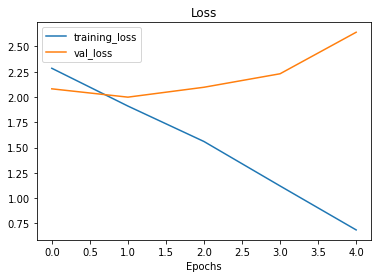

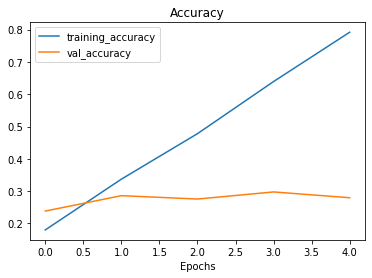

In [75]:
plot_loss_curves(history_10)

Hmm... even with a simplifed model, it looks like our model is still dramatically overfitting the training data.

What else could we try?

How about **data augmentation**?

Data augmentation makes it harder for the model to learn on the training data and in turn, hopefully making the patterns it learns more generalizable to unseen data.

To create augmented data, we'll recreate a new `ImageDataGenerator` instance, this time adding some parameters such as `rotation_range` and `horizontal_flip` to manipulate our images.

In [76]:
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224,224),
                                                                   batch_size=32,
                                                                   class_mode='categorical')

Found 7500 images belonging to 10 classes.


Now we've got augmented data, let's see how it works with the same model as before (`model_10`).

Rather than rewrite the model from scratch, we can clone it using a handy function in TensorFlow called `clone_model` which can take an existing model and rebuild it in the same format.

The cloned version will not include any of the weights (patterns) the original model has learned. So when we train it, it'll be like training a model from scratch.

>🔑 Note: One of the key practices in deep learning and machine learning in general is to be a serial experimenter. That's what we're doing here. Trying something, seeing if it works, then trying something else. A good experiment setup also keeps track of the things you change, for example, that's why we're using the same model as before but with different data. The model stays the same but the data changes, this will let us know if augmented training data has any influence over performance.

In [80]:
# Clone the model (use the same architecture)
model_11 = tf.keras.models.clone_model(model_10)

# Compile the cloned model (same setup as used for model_10)
model_11.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_11 = model_11.fit(train_data_augmented, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 122s 519ms/step - loss: 2.2535 - accuracy: 0.1801 - val_loss: 2.0494 - val_accuracy: 0.2544
Epoch 2/5
235/235 [==============================] - 122s 517ms/step - loss: 2.0688 - accuracy: 0.2633 - val_loss: 1.9202 - val_accuracy: 0.3332
Epoch 3/5
235/235 [==============================] - 122s 518ms/step - loss: 2.0104 - accuracy: 0.2916 - val_loss: 1.9087 - val_accuracy: 0.3268
Epoch 4/5
235/235 [==============================] - 121s 516ms/step - loss: 1.9690 - accuracy: 0.3164 - val_loss: 1.8101 - val_accuracy: 0.3752
Epoch 5/5
235/235 [==============================] - 122s 520ms/step - loss: 1.9448 - accuracy: 0.3277 - val_loss: 1.8046 - val_accuracy: 0.3832


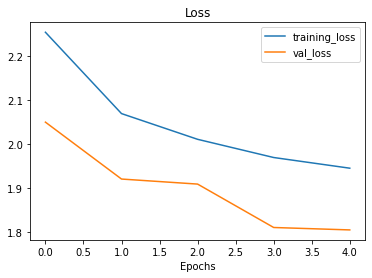

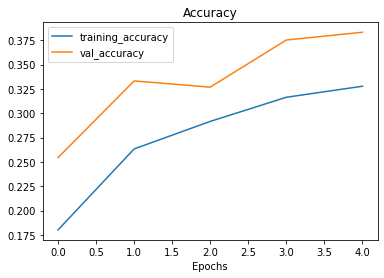

In [81]:
plot_loss_curves(history_11)

Woah! That's looking much better, the loss curves are much closer to eachother. Although our model didn't perform as well on the augmented training set, it performed much better on the validation dataset.

It even looks like if we kept it training for longer (more epochs) the evaluation metrics might continue to improve.

###7. Repeat until satisfied
We could keep going here. Restructuring our model's architecture, adding more layers, trying it out, adjusting the learning rate, trying it out, trying different methods of data augmentation, training for longer. But as you could imagine, this could take a fairly long time.

Good thing there's still one trick we haven't tried yet and that's **transfer learning**.

However, we'll save that for the next notebook where you'll see how rather than design our own models from scratch we leverage the patterns another model has learned for our own task.

In the meantime, let's make a prediction with our trained multi-class model.

##Making a prediction with our trained model
What good is a model if you can't make predictions with it?

Let's first remind ourselves of the classes our multi-class model has been trained on and then we'll download some of own custom images to work with.

In [82]:
# What classes has our model been trained on?
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [83]:
# -q is for "quiet"
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

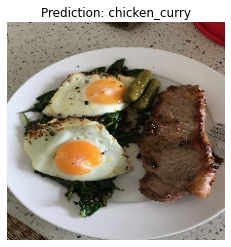

In [84]:
# Make a prediction using model_11
pred_and_plot(model=model_11, 
              filename="03-steak.jpeg", 
              class_names=class_names)

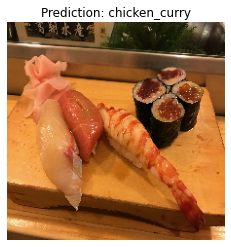

In [85]:
pred_and_plot(model_11, "03-sushi.jpeg", class_names)

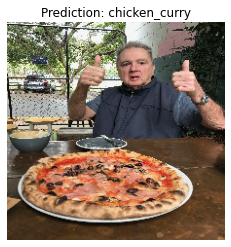

In [86]:
pred_and_plot(model_11, "03-pizza-dad.jpeg", class_names)

`chicken_curry` again? There must be something wrong...

I think it might have to do with our `pred_and_plot` function.

Let's makes a prediction without using the function and see where it might be going wrong.

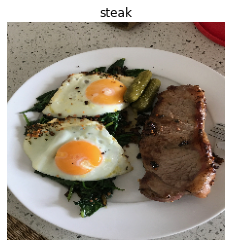

In [87]:
# Load in and preprocess our custom image
img = load_and_prep_image("03-steak.jpeg")

# Make a prediction
pred = model_11.predict(tf.expand_dims(img, axis=0))

# Match the prediction class to the highest prediction probability
pred_class = class_names[pred.argmax()]
plt.imshow(img)
plt.title(pred_class)
plt.axis(False);

Much better! There must be something up with our `pred_and_plot` function.

And I think I know what it is.

The `pred_and_plot` function was designed to be used with `binary classification` models where as our current model is a `multi-class classification` model.

The main difference lies in the output of the predict function.

In [88]:
# Check the output of the predict function
pred = model_11.predict(tf.expand_dims(img, axis=0))
pred

array([[0.0467088 , 0.06141605, 0.02425028, 0.16968845, 0.05291363,
        0.04990405, 0.0128023 , 0.09917113, 0.405511  , 0.07763437]],
      dtype=float32)

Since our model has a `'softmax'` activation function and 10 output neurons, it outputs a prediction probability for each of the classes in our model.

The class with the highest probability is what the model believes the image contains.

We can find the maximum value index using `argmax` and then use that to index our `class_names` list to output the predicted class.

In [89]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

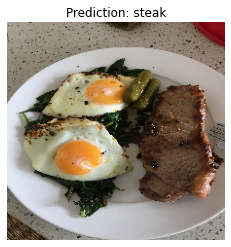

In [90]:
pred_and_plot(model_11, "03-steak.jpeg", class_names)

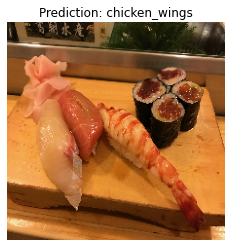

In [91]:
pred_and_plot(model_11, "03-sushi.jpeg", class_names)

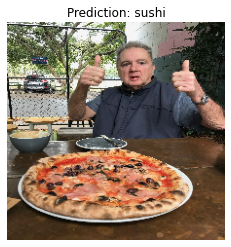

In [92]:
pred_and_plot(model_11, "03-pizza-dad.jpeg", class_names)

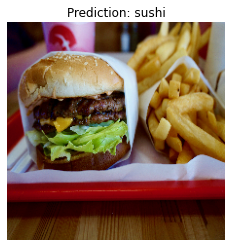

In [93]:
pred_and_plot(model_11, "03-hamburger.jpeg", class_names)

## Saving and loading our model

Once you've trained a model, you probably want to be able to save it and load it somewhere else.

To do so, we can use the `save` and `load_model` functions.

In [94]:
# Save a model
model_11.save("saved_trained_model")

INFO:tensorflow:Assets written to: saved_trained_model/assets


In [95]:
# Load in a model and evaluate it
loaded_model_11 = tf.keras.models.load_model("saved_trained_model")
loaded_model_11.evaluate(test_data)

79/79 [==============================] - 13s 156ms/step - loss: 1.8046 - accuracy: 0.3832


[1.804649829864502, 0.3831999897956848]

In [96]:
# Compare our unsaved model's results (same as above)
model_11.evaluate(test_data)

79/79 [==============================] - 12s 157ms/step - loss: 1.8046 - accuracy: 0.3832


[1.8046495914459229, 0.3831999897956848]